In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,FastICA,TruncatedSVD
from sklearn.feature_selection import SelectKBest,RFE,f_classif,chi2,mutual_info_classif
from sklearn.linear_model import LogisticRegression
import time

In [2]:
hp={
    "cov_thresh":0.8,
    'ex_var' : 0.7, # explained variace
    'knn_k': 5,
    'rforest_nestimator':1000,
    'max_depth':3
}

# load data

In [3]:
df = pd.read_csv('breast-cancer.csv')

print(df.head())

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

In [4]:
df = df.drop('id', axis=1)
print(df.columns)

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [6]:
null_counts = df.isnull().sum()
columns_with_nulls = null_counts[null_counts > 0]
print("columns with null values:", columns_with_nulls)

columns with null values: Series([], dtype: int64)


no null data , no categorical data that require one hot encoding too

In [7]:
df['diagnosis'].value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

In [8]:
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0}) # malignet (badkhim), benign (khoshkhim)

In [9]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


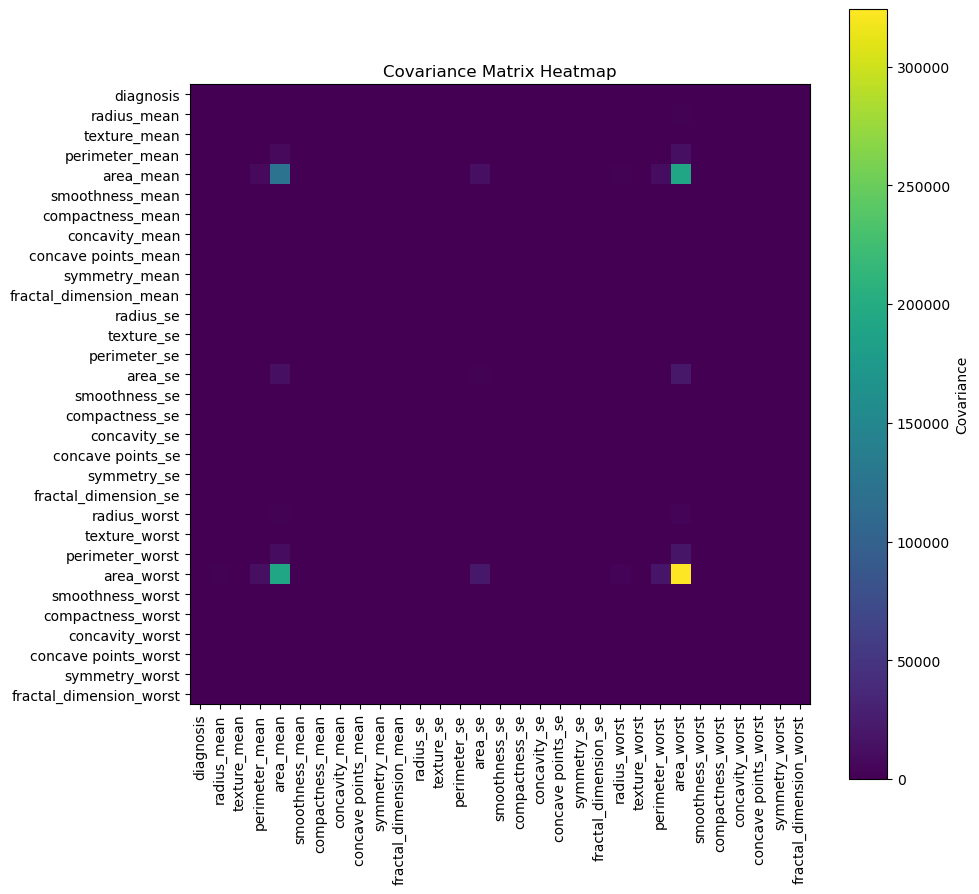

In [10]:
cov_matrix = df.cov()

plt.figure(figsize=(10, 10))
plt.imshow(cov_matrix)
plt.colorbar(label='Covariance')
plt.xticks(range(len(cov_matrix.columns)), cov_matrix.columns,rotation=90)
plt.yticks(range(len(cov_matrix.index)), cov_matrix.index)
plt.title('Covariance Matrix Heatmap')
plt.show()

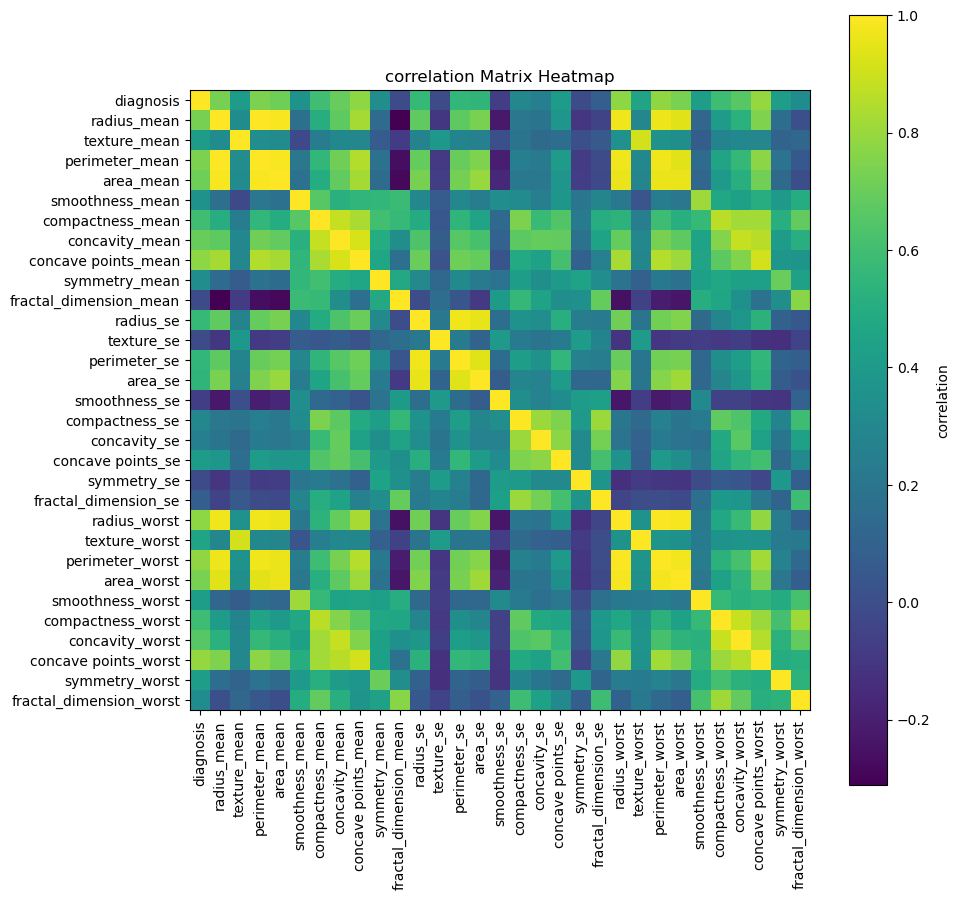

In [11]:
corr_matrix = df.corr() # pandas automaticly standardize

plt.figure(figsize=(10, 10))
plt.imshow(corr_matrix)
plt.colorbar(label='correlation')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns,rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title('correlation Matrix Heatmap')
plt.show()

In [12]:
print(f"Feature with strong correlation (> {hp["cov_thresh"]} or < {-hp["cov_thresh"]}):\n")
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):  # avoid duplicates and self correlation (upper triangle)
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > hp["cov_thresh"]:
            print(f"{corr_matrix.columns[i]} - {corr_matrix.columns[j]}: {corr_value}")

Feature with strong correlation (> 0.8 or < -0.8):

radius_mean - perimeter_mean: 0.9978552814938109
radius_mean - area_mean: 0.9873571700566127
radius_mean - concave points_mean: 0.8225285223871786
radius_mean - radius_worst: 0.9695389726112055
radius_mean - perimeter_worst: 0.9651365139559871
radius_mean - area_worst: 0.9410824595860461
texture_mean - texture_worst: 0.912044588840421
perimeter_mean - area_mean: 0.9865068039913907
perimeter_mean - concave points_mean: 0.8509770412528191
perimeter_mean - radius_worst: 0.9694763634663146
perimeter_mean - perimeter_worst: 0.9703868870426394
perimeter_mean - area_worst: 0.9415498080023068
area_mean - concave points_mean: 0.8232688686524342
area_mean - area_se: 0.8000859212343201
area_mean - radius_worst: 0.9627460860470841
area_mean - perimeter_worst: 0.9591195743552645
area_mean - area_worst: 0.9592133256498998
smoothness_mean - smoothness_worst: 0.8053241954943627
compactness_mean - concavity_mean: 0.8831206701772507
compactness_mean - 

In [13]:
X = df.iloc[:, 1:]   # all columns except first
y = df.iloc[:, 0]    # only first column


X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, # dataset is small so i use 0.8       
    random_state=42,     
    shuffle=True         
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (455, 30)
X_test shape: (114, 30)


In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# normal data

In [15]:
knn = KNeighborsClassifier(n_neighbors=hp["knn_k"])
knn.fit(X_train_scaled, y_train)

start_time = time.time()
y_pred = knn.predict(X_test_scaled)
end_time = time.time()
print(f"prediction time : {end_time-start_time:.4f}")
print(f"train accuracy : {knn.score(X_train_scaled,y_train)}")
print(f"test accuracy : {knn.score(X_test_scaled,y_test)}")

prediction time : 0.2174
train accuracy : 0.9802197802197802
test accuracy : 0.9473684210526315


In [16]:
# no scale 
knn = KNeighborsClassifier(n_neighbors=hp["knn_k"])
knn.fit(X_train, y_train)

start_time = time.time()
y_pred = knn.predict(X_test)
end_time = time.time()
print(f"prediction time : {end_time-start_time:.4f}")
print(f"train accuracy : {knn.score(X_train,y_train)}")
print(f"test accuracy : {knn.score(X_test,y_test)}")

prediction time : 0.0130
train accuracy : 0.9406593406593406
test accuracy : 0.956140350877193


In [17]:
forest = RandomForestClassifier(n_estimators=hp["rforest_nestimator"],random_state=42)
forest.fit(X_train_scaled, y_train)

start_time = time.time()
y_pred = forest.predict(X_test_scaled)
end_time = time.time()
print(f"prediction time : {end_time-start_time:.4f}")
print(f"train accuracy : {forest.score(X_train_scaled,y_train)}")
print(f"test accuracy : {forest.score(X_test_scaled,y_test)}")

prediction time : 0.0359
train accuracy : 1.0
test accuracy : 0.9649122807017544


In [18]:
# no scale
forest = RandomForestClassifier(n_estimators=hp["rforest_nestimator"],random_state=42)
forest.fit(X_train, y_train)

start_time = time.time()
y_pred = forest.predict(X_test)
end_time = time.time()
print(f"prediction time : {end_time-start_time:.4f}")
print(f"train accuracy : {forest.score(X_train,y_train)}")
print(f"test accuracy : {forest.score(X_test,y_test)}")

prediction time : 0.0248
train accuracy : 1.0
test accuracy : 0.9649122807017544


In [36]:
# no scale
forest = RandomForestClassifier(n_estimators=hp["rforest_nestimator"],max_depth=hp["max_depth"],random_state=42)
forest.fit(X_train, y_train)

start_time = time.time()
y_pred = forest.predict(X_test)
end_time = time.time()
print(f"prediction time : {end_time-start_time:.4f}")
print(f"train accuracy : {forest.score(X_train,y_train)}")
print(f"test accuracy : {forest.score(X_test,y_test)}")

prediction time : 0.0251
train accuracy : 0.9802197802197802
test accuracy : 0.9649122807017544


In [19]:
forest = RandomForestClassifier(n_estimators=hp["rforest_nestimator"],max_depth=hp["max_depth"],random_state=42)
forest.fit(X_train_scaled, y_train)

start_time = time.time()
y_pred = forest.predict(X_test_scaled)
end_time = time.time()
print(f"prediction time : {end_time-start_time:.4f}")
print(f"train accuracy : {forest.score(X_train_scaled,y_train)}")
print(f"test accuracy : {forest.score(X_test_scaled,y_test)}")

prediction time : 0.0337
train accuracy : 0.9802197802197802
test accuracy : 0.9649122807017544


# PCA

In [20]:
pca = PCA(n_components=hp["ex_var"],random_state=42)  # Choose enough components to explain 50% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("number of components selected:", pca.n_components_)
print("explained variance ratio of selected components:", pca.explained_variance_ratio_)
print("total explained variance:", sum(pca.explained_variance_ratio_))

number of components selected: 3
explained variance ratio of selected components: [0.43502782 0.19500007 0.09781519]
total explained variance: 0.7278430734090058


In [21]:
knn = KNeighborsClassifier(n_neighbors=hp["knn_k"])
knn.fit(X_train_pca, y_train)

start_time = time.time()
y_pred = knn.predict(X_test_pca)
end_time = time.time()
print(f"prediction time : {end_time-start_time:.4f}")
print(f"train accuracy : {knn.score(X_train_pca,y_train)}")
print(f"test accuracy : {knn.score(X_test_pca,y_test)}")

prediction time : 0.0082
train accuracy : 0.9538461538461539
test accuracy : 0.9210526315789473


In [22]:
forest = RandomForestClassifier(n_estimators=hp["rforest_nestimator"],random_state=42)
forest.fit(X_train_pca, y_train)

start_time = time.time()
y_pred = forest.predict(X_test_pca)
end_time = time.time()
print(f"prediction time : {end_time-start_time:.4f}")
print(f"train accuracy : {forest.score(X_train_pca,y_train)}")
print(f"test accuracy : {forest.score(X_test_pca,y_test)}")

prediction time : 0.0422
train accuracy : 1.0
test accuracy : 0.9385964912280702


# SVD

In [ ]:
for i in range(1,X_train.shape[1]+1,1): # we could just fit once and sum over variance ratio list
    svd = TruncatedSVD(n_components=i,random_state=42)
    svd.fit(X_train_scaled)
    if(sum(svd.explained_variance_ratio_)>=hp["ex_var"]):
        break

X_train_svd = svd.transform(X_train_scaled)
X_test_svd = svd.transform(X_test_scaled)
print("number of components selected:", i)
print("explained variance ratio of selected components:", svd.explained_variance_ratio_)
print("total explained variance:", sum(svd.explained_variance_ratio_))

number of components selected: 3
explained variance ratio of selected components: [0.43502782 0.19500007 0.09781519]
total explained variance: 0.7278430734090067


In [24]:
knn = KNeighborsClassifier(n_neighbors=hp["knn_k"])
knn.fit(X_train_svd, y_train)

start_time = time.time()
y_pred = knn.predict(X_test_svd)
end_time = time.time()
print(f"prediction time : {end_time-start_time:.4f}")
print(f"train accuracy : {knn.score(X_train_svd,y_train)}")
print(f"test accuracy : {knn.score(X_test_svd,y_test)}")

prediction time : 0.0040
train accuracy : 0.9538461538461539
test accuracy : 0.9210526315789473


In [25]:
forest = RandomForestClassifier(n_estimators=hp["rforest_nestimator"],random_state=42)
forest.fit(X_train_svd, y_train)

start_time = time.time()
y_pred = forest.predict(X_test_svd)
end_time = time.time()
print(f"prediction time : {end_time-start_time:.4f}")
print(f"train accuracy : {forest.score(X_train_svd,y_train)}")
print(f"test accuracy : {forest.score(X_test_svd,y_test)}")

prediction time : 0.0374
train accuracy : 1.0
test accuracy : 0.9385964912280702


# ICA

In [26]:
ica = FastICA(n_components=int(X_train.shape[1]/2),random_state=42)  # choose n comp as half of the features
X_train_ica = ica.fit_transform(X_train_scaled)
X_test_ica = ica.transform(X_test_scaled)

print("number of components selected:", int(X_train.shape[1]/2))

number of components selected: 15


In [27]:
knn = KNeighborsClassifier(n_neighbors=hp["knn_k"])
knn.fit(X_train_ica, y_train)

start_time = time.time()
y_pred = knn.predict(X_test_ica)
end_time = time.time()
print(f"prediction time : {end_time-start_time:.4f}")
print(f"train accuracy : {knn.score(X_train_ica,y_train)}")
print(f"test accuracy : {knn.score(X_test_ica,y_test)}")

prediction time : 0.0086
train accuracy : 0.945054945054945
test accuracy : 0.8859649122807017


In [28]:
forest = RandomForestClassifier(n_estimators=hp["rforest_nestimator"],random_state=42)
forest.fit(X_train_ica, y_train)

start_time = time.time()
y_pred = forest.predict(X_test_ica)
end_time = time.time()
print(f"prediction time : {end_time-start_time:.4f}")
print(f"train accuracy : {forest.score(X_train_ica,y_train)}")
print(f"test accuracy : {forest.score(X_test_ica,y_test)}")

prediction time : 0.0604
train accuracy : 1.0
test accuracy : 0.9298245614035088


# anova

In [29]:
col_names = df.columns[1:].to_numpy()
print(col_names)

['radius_mean' 'texture_mean' 'perimeter_mean' 'area_mean'
 'smoothness_mean' 'compactness_mean' 'concavity_mean'
 'concave points_mean' 'symmetry_mean' 'fractal_dimension_mean'
 'radius_se' 'texture_se' 'perimeter_se' 'area_se' 'smoothness_se'
 'compactness_se' 'concavity_se' 'concave points_se' 'symmetry_se'
 'fractal_dimension_se' 'radius_worst' 'texture_worst' 'perimeter_worst'
 'area_worst' 'smoothness_worst' 'compactness_worst' 'concavity_worst'
 'concave points_worst' 'symmetry_worst' 'fractal_dimension_worst']


In [30]:
selector = SelectKBest(score_func=f_classif, k=int(X_train.shape[1]/2))
X_train_anova = selector.fit_transform(X_train_scaled, y_train)
X_test_anova = selector.transform(X_test_scaled)
print(f"selected features : {col_names[selector.get_support()]}")

selected features : ['radius_mean' 'perimeter_mean' 'area_mean' 'compactness_mean'
 'concavity_mean' 'concave points_mean' 'radius_se' 'perimeter_se'
 'area_se' 'radius_worst' 'perimeter_worst' 'area_worst'
 'compactness_worst' 'concavity_worst' 'concave points_worst']


In [50]:
knn = KNeighborsClassifier(n_neighbors=hp["knn_k"])
knn.fit(X_train_anova, y_train)

start_time = time.time()
y_pred = knn.predict(X_test_anova)
end_time = time.time()
print(f"prediction time : {end_time-start_time:.4f}")
print(f"train accuracy : {knn.score(X_train_anova,y_train)}")
print(f"test accuracy : {knn.score(X_test_anova,y_test)}")

prediction time : 0.0087
train accuracy : 0.9428571428571428
test accuracy : 0.9649122807017544


In [52]:
forest = RandomForestClassifier(n_estimators=hp["rforest_nestimator"],random_state=42)
forest.fit(X_train_anova, y_train)

start_time = time.time()
y_pred = forest.predict(X_test_anova)
end_time = time.time()
print(f"prediction time : {end_time-start_time:.4f}")
print(f"train accuracy : {forest.score(X_train_anova,y_train)}")
print(f"test accuracy : {forest.score(X_test_anova,y_test)}")

prediction time : 0.0290
train accuracy : 1.0
test accuracy : 0.956140350877193


# mutual info

In [53]:
selector = SelectKBest(score_func=mutual_info_classif, k=int(X_train.shape[1]/2))
X_train_mutual_info_classif = selector.fit_transform(X_train_scaled, y_train)
X_test_mutual_info_classif = selector.transform(X_test_scaled)
print(f"selected features : {col_names[selector.get_support()]}")

print("KNN")
knn = KNeighborsClassifier(n_neighbors=hp["knn_k"])
knn.fit(X_train_mutual_info_classif, y_train)

start_time = time.time()
y_pred = knn.predict(X_test_mutual_info_classif)
end_time = time.time()
print(f"prediction time : {end_time-start_time:.4f}")
print(f"train accuracy : {knn.score(X_train_mutual_info_classif,y_train)}")
print(f"test accuracy : {knn.score(X_test_mutual_info_classif,y_test)}")

print("Random Forest")
forest = RandomForestClassifier(n_estimators=hp["rforest_nestimator"],random_state=42)
forest.fit(X_train_mutual_info_classif, y_train)

start_time = time.time()
y_pred = forest.predict(X_test_mutual_info_classif)
end_time = time.time()
print(f"prediction time : {end_time-start_time:.4f}")
print(f"train accuracy : {forest.score(X_train_mutual_info_classif,y_train)}")
print(f"test accuracy : {forest.score(X_test_mutual_info_classif,y_test)}")

selected features : ['radius_mean' 'perimeter_mean' 'area_mean' 'compactness_mean'
 'concavity_mean' 'concave points_mean' 'radius_se' 'perimeter_se'
 'area_se' 'radius_worst' 'perimeter_worst' 'area_worst'
 'compactness_worst' 'concavity_worst' 'concave points_worst']
KNN
prediction time : 0.0052
train accuracy : 0.9428571428571428
test accuracy : 0.9649122807017544
Random Forest
prediction time : 0.0510
train accuracy : 1.0
test accuracy : 0.956140350877193


chi2 not suitable here

# RFE

In [34]:
model = LogisticRegression()

rfe = RFE(estimator=model, n_features_to_select=int(X_train.shape[1]/2))

X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)
print(f"selected features : {col_names[rfe.support_]}")

selected features : ['radius_mean' 'area_mean' 'concave points_mean' 'radius_se'
 'perimeter_se' 'area_se' 'compactness_se' 'radius_worst' 'texture_worst'
 'perimeter_worst' 'area_worst' 'smoothness_worst' 'concavity_worst'
 'concave points_worst' 'symmetry_worst']


In [35]:
print("KNN")
knn = KNeighborsClassifier(n_neighbors=hp["knn_k"])
knn.fit(X_train_rfe, y_train)

start_time = time.time()
y_pred = knn.predict(X_test_rfe)
end_time = time.time()
print(f"prediction time : {end_time-start_time:.4f}")
print(f"train accuracy : {knn.score(X_train_rfe,y_train)}")
print(f"test accuracy : {knn.score(X_test_rfe,y_test)}")

print("Random Forest")
forest = RandomForestClassifier(n_estimators=hp["rforest_nestimator"],random_state=42)
forest.fit(X_train_rfe, y_train)

start_time = time.time()
y_pred = forest.predict(X_test_rfe)
end_time = time.time()
print(f"prediction time : {end_time-start_time:.4f}")
print(f"train accuracy : {forest.score(X_train_rfe,y_train)}")
print(f"test accuracy : {forest.score(X_test_rfe,y_test)}")

KNN
prediction time : 0.0049
train accuracy : 0.9824175824175824
test accuracy : 0.9649122807017544
Random Forest
prediction time : 0.0318
train accuracy : 1.0
test accuracy : 0.956140350877193
